In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
from IPython.display import clear_output  # 引入 clear_output
# torch.manual_seed(seed=42)  

os.makedirs("fun_images", exist_ok=True)


In [30]:
layer_num=4
hidden_num=128

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [31]:
def potential(x):
    poten=2*x**2
    return poten

In [32]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

La =0
Lb =20
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device,requires_grad=True)
grid=grid[1:-1].unsqueeze(-1)

en_num=20

#离心势能：-k*(l+1)*l/x**2

# 先给出固定的矩阵元素
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap


In [33]:
l=0
centrifugal_poten=-b_lap*(l+1)*l/grid**2
V_diag=potential(grid)+centrifugal_poten
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
real_en=eigenvalues[:en_num]    
print("real_en",real_en)

real_en tensor([ 2.9968,  6.9994, 10.9971, 15.0071, 19.0035, 23.0124, 27.0024, 30.9873,
        34.9971, 38.9959, 42.9946, 46.9966, 50.9965, 54.9954, 58.9946, 62.9934,
        66.9931, 70.9932, 74.9920, 78.9905], device='cuda:0',
       grad_fn=<SliceBackward0>)


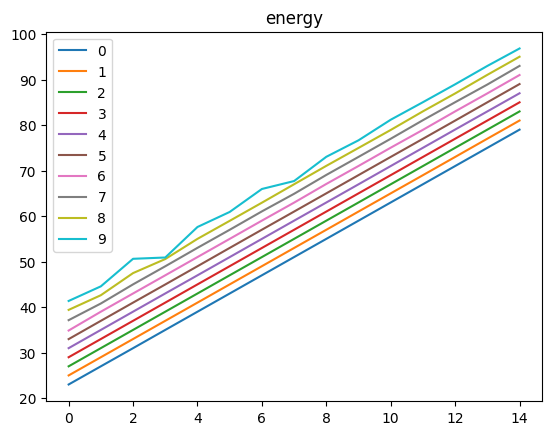

In [34]:
for l in range(10):
    centrifugal_poten=-b_lap*(l+1)*l/grid**2
    V_diag=potential(grid)+centrifugal_poten
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    real_en=eigenvalues[5:en_num]    
    plt.plot(real_en.detach().cpu().numpy(),label=str(l))

plt.legend()
plt.title("energy")
plt.show()

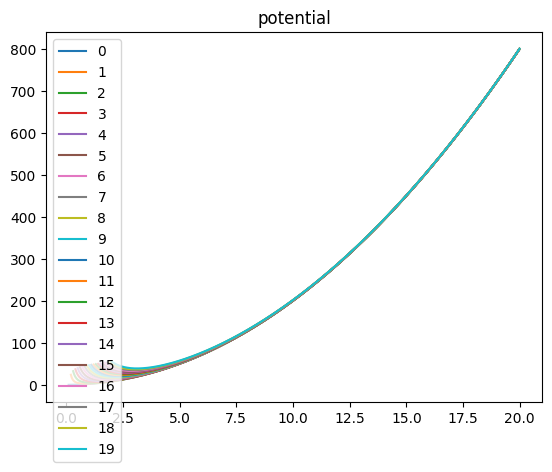

In [35]:
for l in range(20):
    grid=grid[20:]
    centrifugal_poten=-b_lap*(l+1)*l/grid**2
    V_diag=potential(grid)+centrifugal_poten
    plt.plot(grid.detach().cpu().numpy(),V_diag.detach().cpu().numpy(),label=str(l))
plt.legend()
plt.title("potential")
plt.show()